In [1]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices
using KrylovKit, IterTools, FFTW
Random.seed!(123);

In [2]:
# important functions
include("localization3d.jl")
#=
using Slepians, FastGaussQuadrature

"""

    scale_quad_nodez(Nqz, z)
    
Scale the quadrature nodes in z to the correct interval

# Arguments
- `Nqz`: Number of quadrature nodes in z
- `z`: Levels in z given

# Outputs
- `colf`: Zero crossing indices where the thph z-coordinate and quadrature node intersect
- `th`: z-level at which crossings are required
- `wqz`: Quadrature weights in the z-direction

"""
function scale_quad_nodez(Nqz, z)
    # Calculate blanks, z-axis GL points regardless of the data range
    qz, wqz = FastGaussQuadrature.gausslegendre(Nqz)

    mn, mx = (minimum(z), maximum(z))
    # Scale the z-quadrature points to the min-max interval
    th = qz*(abs(mx - mn)/2) .+ (mx + mn)/2;

    # We need to find the two z's between which each quadrature point (th) lives
    xmth = repeat(z, 1, length(th)) .- repeat(th', length(z), 1)
    dsx = diff(sign.(xmth), dims = 1)
    col = findall(x -> (x == 2), dsx)
    colf = map(c -> Tuple(c)[1], col)
    return colf, th, wqz
end

"""
    interpcontour(z, z0, thph)

# Arguments
- `z::Vector` the two z-values between which the level z0 falls. 
- `z0<:Number` the z-level of the desired contour
- `thph::Matrix` the array of arrays of zyx coordinates (first N are at level z[1] second are at level z[2])
"""
function interpcontourvec(z, z0, thph, N)
    Nmax, ind = findmax(N)
    thph_long, thph_short = (ind == 1) ? (thph[1:Nmax,:], thph[(Nmax + 1):end,:]) : (thph[1:(end - Nmax - 1),:], thph[(end - Nmax):end,:])
    newcurve = zeros(Nmax, 3)
    for j in 1:Nmax
        # Note that I cheated here - the comment on the next line doesn't give the correct result!
        closest = j #findmin(sum(abs2.(repeat(thph_long[j,2:3]', size(thph_short,1), 1) .- thph_short[2:3]), dims=2))[2][1]
        newcurve[j,:] = interp2(z, vcat(thph_long[j,:]', thph_short[closest,:]'), z0)
    end
    return newcurve
end

"""

    fill2d(colf, thpha, th, Nqx, Nqy, N)
    
Fill each 2D level with nodes in x and y

# Arguments
- `colf`: Zero crossing indices where the thph z-coordinate and quadrature node intersect
- `thpha`: The array of arrays of closed curves where the columns are in order (z, y, x)
- `th`: z-level at which crossings are required
- `Nqx`: Number of quadrature nodes in x
- `Nqy`: Number of quadrature nodes in y
- `N::Int64`: Number of points in each closed curve

# Outputs
- `pkg`: The array containing quadrature nodes in x, y at each level z

"""
function fill2d(z, colf, thpha, th, Nqx, Nqy)
    N = map(i -> size(thpha[i], 1), 1:length(thpha))
    newcurve = map(i -> interpcontourvec(Float64.(z[colf[i]:(colf[i] + 1)]), th[i], vcat(thpha[colf[i]], thpha[(colf[i] + 1)]), N[colf[i]:(colf[i] + 1)]), 1:length(th))
    pkg = map(nc -> get_quadrature_nodes_2D(nc[:,3], nc[:,2], Nqx, Nqy), newcurve);
    return newcurve, pkg
end

"""

    getnodeswts3d(szs, pkg, th, wqz)
    
Get the nodes and weights in 3D

# Arguments
- `szs::Tuple{Int64}`: number of quadrature nodes in each dimension
- `pkg`: The array containing quadrature nodes in x, y at each level z
- `th`: z-level at which crossings are required 
- `wqz`: Quadrature weights in the z-direction

# Outputs
- `no`: The quadrature nodes in Tuple format
- `sqwt`: squared weight associated with each node
- `ev`: The even grid of size szs

"""
function getnodeswts3d(szs, pkg, th, wqz)
    QX = mapreduce(p -> p[1][:], vcat, pkg)
    QY = mapreduce(p -> p[2][:], vcat, pkg)
    QZ = mapreduce(i -> ones(size(pkg[i][2][:]))*th[i], vcat, 1:length(pkg)); #kron(th, ones(Nqx, Nqy))[:]

    wts = mapreduce(i -> ones(size(pkg[i][2][:]))*wqz[i], vcat, 1:length(pkg));

    no    = map(i->(QX[i], QY[i], QZ[i]), 1:prod(size(QX)))
    sqwt = sqrt.(wts);
    ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]), range(minimum(QZ), maximum(QZ), length = szs[3]) ]...)))

    return no, sqwt, ev
end

"""

    slepian3(szs, N, z, thpha; <kwargs>)
    
Compute the 3D localization problem with boundary defined as a set of stacked contours

# Arguments
- `szs::Tuple{Int64}`: number of quadrature nodes in each dimension
- `N::Union{Int64, Array{Int64}}`: Number of points in each closed curve
- `z`: Levels in z given. These must correspond to the order in thpha
- `thpha`: The array of arrays of closed curves where the columns are in order (z, y, x)

# Optional Keyword Arguments
- `M::Int64 = 3`: Number of Slepians to output
- `Kp::Vector{Float64}`: Bandwidth (radius) in units of number of pixels
- `exact::Bool`: Whether or not to use the approximation using HODLR matrices (false) or not (true)
- `prec::Float63`: If exact = false, state precision of the approximation
- `lvl::Int64`: Number of levels of the HODLR approximation
- `maxrank::Int64`: Maximum rank of the off-diagonal matrices
- `int::Tuple{Int64}`: output size (if different than szs) to interpolate to (Nyström)

# Outputs
- `s`: 3D Slepians
- `sl`: eigenvalues

"""
function slepian3(szs, N::Int64, z, thpha; M = 3, Kp = [4.0], exact = false,
                    prec = 1e-8, lvl = 6, 
                    maxrank = 256, int = szs)
    Nqx, Nqy, Nqz = szs 
    # compute the nodes - first scale in z
    colf, th, wqz = scale_quad_nodez(Nqz, z)
    # compute the quad nodes in 2d at each level
    pkg = fill2d(z, colf, thpha, th, Nqx, Nqy)[2]

    # collate nodes weights
    no, sqwt, ev = getnodeswts3d(szs, pkg, th, wqz)

    # do the integration
    s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
            sqwt = sqwt, int = nothing, ev = ev);
    return s, sl
end
        
# Compute the magnitude squared FFT of each component of the vector of matrices sl
SL(sl) = map(i->abs2.(fftshift(fft(sl[i]))), 1:length(sl))  
=#

SL (generic function with 1 method)

# Generate a random 3D surface

For 3D interpolation, some simplifying assumptions have been made:
- the 3D surface has been supplied as a set of contours in z-direction
- these contours are in sorted order (easy to generalize this)

We will just stack a bunch of blobs.

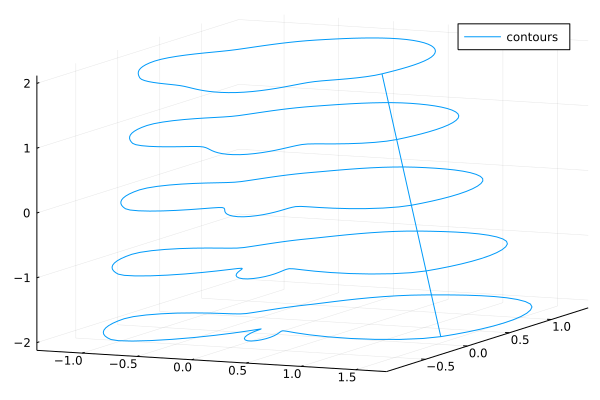

In [3]:
Nz = 5
x, y = blob(Nz,5)

z = collect(-2:2)

Nx = length(x[1])
hcat(x[1], y[1])

# z, y, x is the order
thpha = map(i -> hcat(ones(length(y[i]))*z[i], y[i], x[i]), 1:Nz)

# println(size(thph))
thph = vcat(thpha...)
# This is necessary to close the curve
thph = vcat(thph, thph[1,:]')

p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")

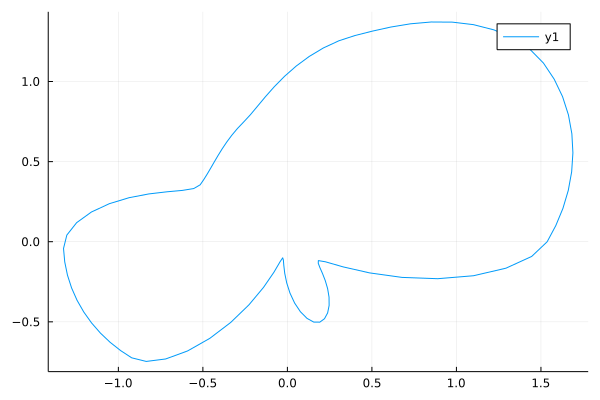

In [4]:
plot(thpha[1][:,3], thpha[1][:,2])

In [5]:
# N = map(i -> size(thpha[i], 1), 1:length(thpha))

# Fill with quadrature nodes

## Get the quadrature nodes and scale to the range in z

In [6]:
Nqx = Nqy = 16
Nqz = 10

# set parameters for the integration

M  = 3
Kp = [4.0]
szs = int = (Nqx, Nqy, Nqz)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256

256

In [7]:
# compute the nodes - first scale in z
colf, th, wqz = scale_quad_nodez(Nqz, z)

([1, 1, 1, 2, 2, 3, 3, 4, 4, 4], [-1.9478130570343435, -1.730126733377969, -1.3588191365980489, -0.8667907882584944, -0.2977486779632624, 0.2977486779632624, 0.8667907882584944, 1.3588191365980489, 1.730126733377969, 1.9478130570343435], [0.06667134430868821, 0.14945134915058048, 0.21908636251598207, 0.2692667193099964, 0.2955242247147528, 0.2955242247147528, 0.2692667193099964, 0.21908636251598207, 0.14945134915058048, 0.06667134430868821])

In [24]:

    
# To get the closed curve at the level th, take the 100 points before and 100 points after 
# the crossing and interpolate each yx


interpcontourvec

In [25]:
# compute the quad nodes in 2d at each level
# N = map(i -> size(thpha[i], 1), 1:length(thpha))

#=
newcurve = map(i -> interpcontourvec(Float64.(z[colf[i]:(colf[i] + 1)]), th[i], vcat(thpha[colf[i]], thpha[(colf[i] + 1)]), N[colf[i]:(colf[i] + 1)]), 1:length(th))

pkg = map(nc -> get_quadrature_nodes_2D(nc[:,3], nc[:,2], Nqx, Nqy), newcurve);
=#

newcurve, pkg = fill2d(z, colf, thpha, th, Nqx, Nqy)


#=
i = 1

z = z[colf[i]:(colf[i] + 1)]
z0 = th[i]
thph = vcat(thpha[colf[i]], thpha[(colf[i] + 1)])
N = [100, 100]
=#

#=
Nmax, ind = findmax(N)
thph_long, thph_short = (ind == 1) ? (thph[1:Nmax,:], thph[(Nmax + 1):end,:]) : (thph[1:(end - Nmax - 1),:], thph[(end - Nmax):end,:])
newcurve = zeros(Nmax, 3)
j=11
#for j in 1:Nmax
    closest = findmin(sum(abs2.(repeat(thph_long[j,:]', size(thph_short,1), 1) .- thph_short), dims=2))[2][1]
    # newcurve[j,:] = interp2(z, vcat(thph_long[j,:]', thph_short[closest,:]'), z0)
#end

closest

=#

([[-1.9478130570343435 0.0 1.5298873847715704; -1.9478130570343435 0.1004408649216731 1.5804549057820194; … ; -1.9478130570343435 -0.09145823210454207 1.4391115779070123; -1.9478130570343435 -3.7471433776328374e-16 1.5298873847715704], [-1.730126733377969 0.0 1.5006552016664279; -1.730126733377969 0.0984430359935222 1.5490187116306482; … ; -1.730126733377969 -0.08985121164209403 1.4138248245965075; -1.730126733377969 -3.675545178689234e-16 1.5006552016664279], [-1.3588191365980489 0.0 1.4507938623085423; -1.3588191365980489 0.09503533887397281 1.495397990281713; … ; -1.3588191365980489 -0.08711011658446585 1.370693205464975; -1.3588191365980489 -3.5534201193975646e-16 1.4507938623085423], [-0.8667907882584944 0.0 1.3847214397052425; -0.8667907882584944 0.09051972001803235 1.4243439230046306; … ; -0.8667907882584944 -0.0834778276532865 1.313538491942975; -0.8667907882584944 -3.39158935769148e-16 1.3847214397052425], [-0.2977486779632623 0.0 1.3083071621186322; -0.2977486779632623 0.0852

In [26]:
# collate nodes weights
no, sqwt, ev = getnodeswts3d(szs, pkg, th, wqz)

([(-0.8748031324578538, -0.7344385960945192, -1.9478130570343435), (-0.871916965401415, -0.7344385960945192, -1.9478130570343435), (-0.8668340781868438, -0.7344385960945192, -1.9478130570343435), (-0.8597370013386713, -0.7344385960945192, -1.9478130570343435), (-0.8508820948985251, -0.7344385960945192, -1.9478130570343435), (-0.8405893622616474, -0.7344385960945192, -1.9478130570343435), (-0.8292307970491444, -0.7344385960945192, -1.9478130570343435), (-0.8172169217626257, -0.7344385960945192, -1.9478130570343435), (-0.8049819458700196, -0.7344385960945192, -1.9478130570343435), (-0.7929680705835009, -0.7344385960945192, -1.9478130570343435)  …  (0.21337651642456548, 1.131251447990941, 1.9478130570343435), (0.23636045208754097, 1.131251447990941, 1.9478130570343435), (0.2597673788324249, 1.131251447990941, 1.9478130570343435), (0.2827513144954004, 1.131251447990941, 1.9478130570343435), (0.3044815660455255, 1.131251447990941, 1.9478130570343435), (0.3241727563634131, 1.131251447990941,

In [194]:
# or you can do it all in one shot, without intermediates:
maxrank = 256
s, sl = slepian3(szs, N[1], z, thpha; 
                M = 3, Kp = [4.0], prec = 1e-8, exact = false, lvl = 6, 
                    maxrank = 256, int = nothing)

(Complex{Float64}[101.37714655472584 + 0.0im, 83.07671403006425 + 0.0im, 67.21577833531741 + 0.0im, 66.20859715776209 + 0.0im, 38.94063822476907 + 0.0im], Array{Complex{Float64},3}[[-0.004499902218029372 + 0.0im -0.004160744783750096 + 0.0im … -0.0026339922200956625 + 0.0im -0.0012428162652703882 + 0.0im; -0.002781406963016562 + 0.0im -0.002174743102659091 + 0.0im … -0.004328158356491716 + 0.0im -0.0029254907732142754 + 0.0im; … ; -0.0007871943081645804 + 0.0im -0.0009307450154063343 + 0.0im … 0.0037221737692430534 + 0.0im 0.0038038431644121856 + 0.0im; 0.0012363831893313487 + 0.0im 0.0011579868998934035 + 0.0im … 0.00339257268491216 + 0.0im 0.003129650625205626 + 0.0im]

[0.002102376140274764 + 0.0im 0.0028314678201063342 + 0.0im … -0.00614575889328236 + 0.0im -0.005627719488694073 + 0.0im; 0.0066966997544537325 + 0.0im 0.007687450515945511 + 0.0im … -0.006235322917511619 + 0.0im -0.006274294277468643 + 0.0im; … ; -0.0044908076741576874 + 0.0im -0.004541646942163995 + 0.0im … 0.000400

# Sanity plot 1 - scaled quadratuer points in z

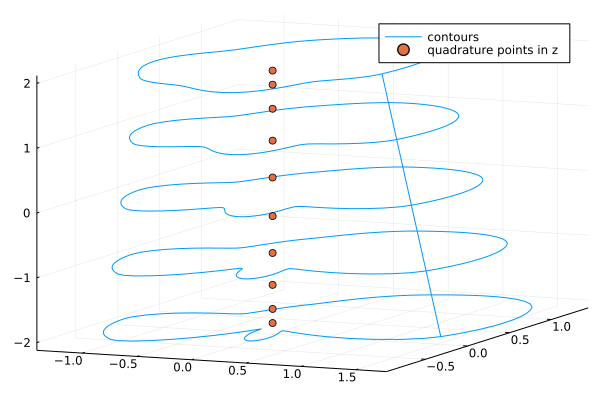

In [13]:
p1 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p1, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")

# Sanity plot II: Show the quadrature closed curves at each z level

Get the (x,y) values at each quadrature level z. 

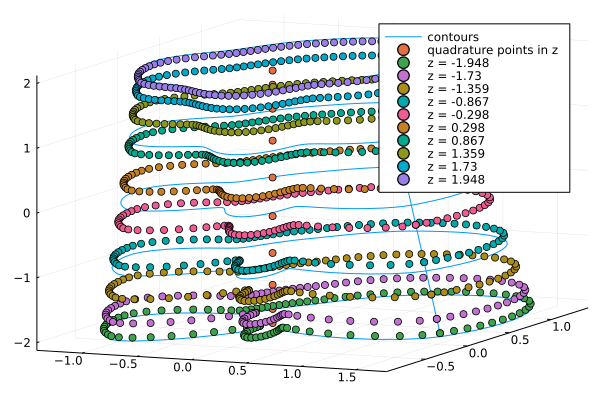

In [14]:
p2 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p2, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")
for i = 1:length(th)
    scatter!(p2, newcurve[i][:,3],newcurve[i][:,2],newcurve[i][:,1], label = "z = $(round(1000*th[i])/1000)")
end
p2

# Sanity plots III - IV: plot in 2D the quadrature nodes we are getting at each level.

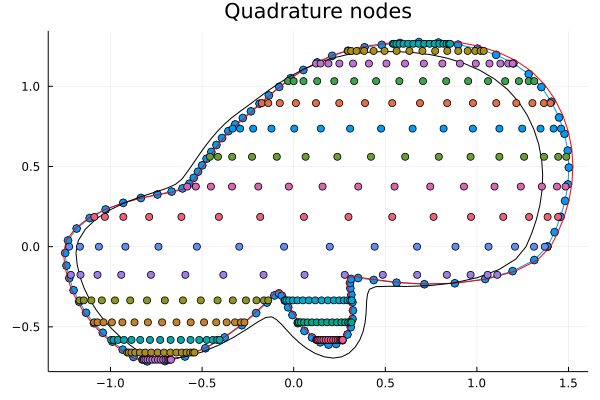

In [20]:
i = 4
N=100
q = plot(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")

plot!(q, thpha[colf[i]][:, 3], thpha[colf[i]][:,2], label = "z = $(thph[colf[i]][1,1])", c = :red)
plot!(q, thpha[colf[i]+1][:, 3], thpha[colf[i]+1][:,2], label = "z = $(thph[colf[i] + 1][1,1])", c = :black)


scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")


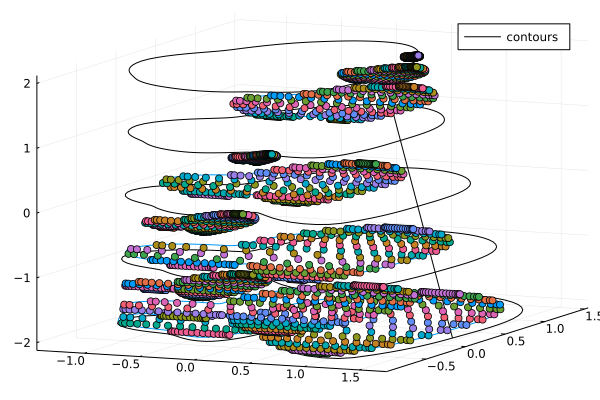

In [83]:
p3 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
for i = 1:10
    plot!(p3, newcurve[i][:,3], newcurve[i][:,2], ones(size(newcurve[i][:,2]))*th[i], c = 1, label = "")
    scatter!(p3, pkg[i][1], pkg[i][2], ones(Nqx,Nqy+1)*th[i] , label = "")
end
p3

# Sanity plot V - Show the sequences

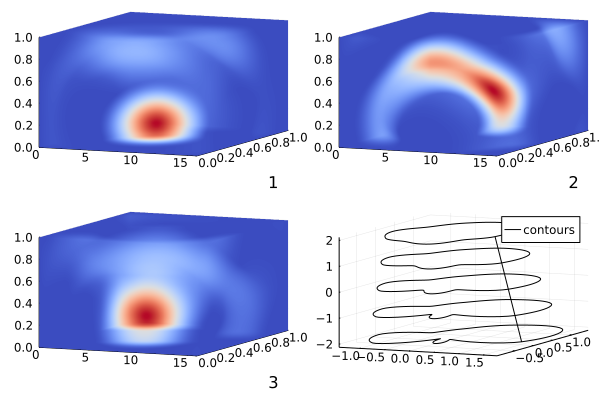

In [16]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ssl = SL(sl)
ran = 1:3
for i = ran
    p1[i] = heatmap( Float64.(sl[i]),
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    #plot!(p1[i], x[1], y[1], legend = false, c = :black)

    # ssl = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(ssl[i]), ylabel = i)
end

psimple = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
plot(p1[1:3]..., psimple)

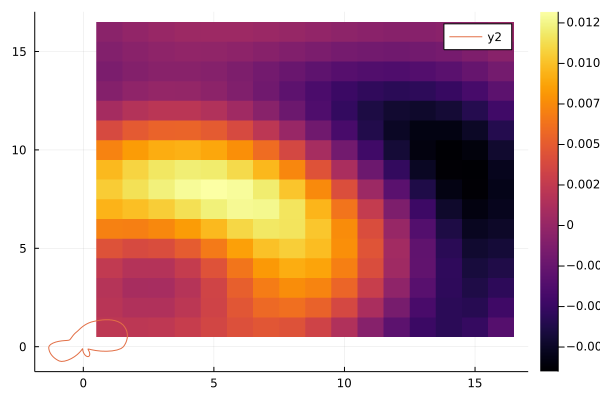

In [17]:
heatmap(Float64.(sl[1][:,:,1]))
plot!(thpha[1][:,3], thpha[1][:,2])

# Sanity plot VI: Show the FFTs

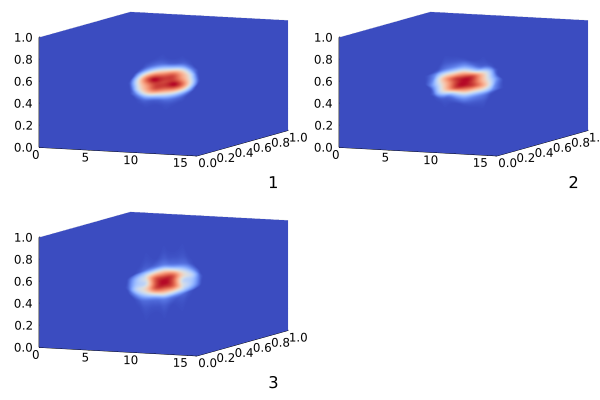

In [18]:
plot(p2[ran]...)